## Installing Dependencies

In [4]:
!pip install gymnasium[box2d] stable-baselines3[extra] moviepy matplotlib

## Discrete Action Wrapper

In [5]:
import gymnasium as gym
import numpy as np

class DiscretizeActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.discrete_actions = [
            np.array([0.0, 0.0, 0.0]),   # Do nothing
            np.array([-1.0, 0.3, 0.0]),  # Steer left + gas
            np.array([1.0, 0.3, 0.0]),   # Steer right + gas
            np.array([0.0, 0.6, 0.0]),   # Go straight (light gas)
            np.array([0.0, 0.0, 0.5]),   # Brake
        ]
        self.action_space = gym.spaces.Discrete(len(self.discrete_actions))

    def action(self, action):
        return self.discrete_actions[action]

## Wrap the CarRacing Env

In [6]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

# Import the wrapper if you put it in utils
# from utils.discrete_action_wrapper import DiscretizeActionWrapper

env = gym.make("CarRacing-v3", render_mode="rgb_array")
env = DiscretizeActionWrapper(env)
env = Monitor(env, filename="../logs/dqn_monitor.csv")
env = DummyVecEnv([lambda: env])

## DQN Training Setup

In [7]:
from stable_baselines3 import DQN

model = DQN(
    policy="MlpPolicy",
    env=env,
    verbose=1,
    tensorboard_log="./dqn_tensorboard/",
    learning_rate=1e-4,
    buffer_size=50_000,
    learning_starts=1_000,
    batch_size=32,
    train_freq=4,
    target_update_interval=1_000,
)

model.learn(total_timesteps=100_000)
model.save("../models/dqn_driftctrl")

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ./dqn_tensorboard/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | -4.49    |
|    exploration_rate | 0.62     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 124      |
|    time_elapsed     | 32       |
|    total_timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.001    |
|    n_updates        | 749      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 870      |
|    ep_rew_mean      | -56.9    |
|    exploration_rate | 0.339    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 115      |
|    time_elapsed     | 60       |
|    total_timesteps  | 6958     |
| train/              |        

## DQN Reward Plot

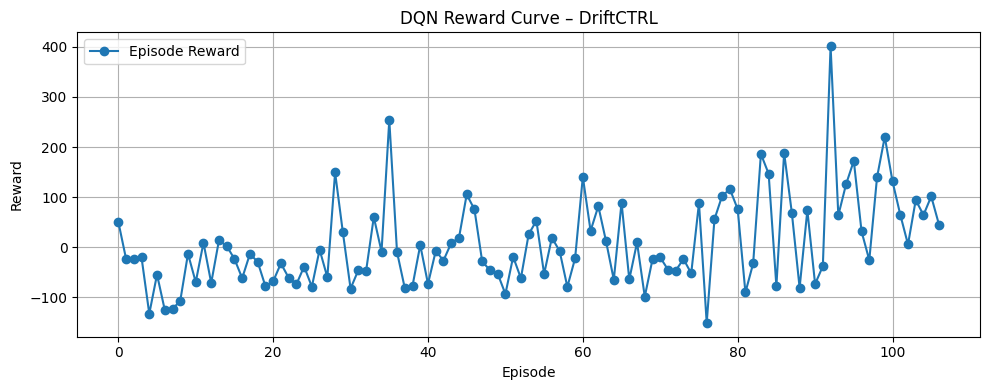

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load reward data from DQN monitor log
reward_data = pd.read_csv("../logs/dqn_monitor.csv", skiprows=1)

# Plot rewards
plt.figure(figsize=(10, 4))
plt.plot(reward_data["r"], marker="o", linestyle="-", label="Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN Reward Curve – DriftCTRL")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## record_video() fucntion

In [9]:
# RECORD VIDEO FUNCTION (supports both PPO and DQN)
import gymnasium as gym
import imageio
import os
import numpy as np

# If you saved the wrapper in a file, import like this:
# from utils.discrete_action_wrapper import DiscretizeActionWrapper

# OR define inline here:
class DiscretizeActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.discrete_actions = [
            np.array([0.0, 0.0, 0.0]),   # Do nothing
            np.array([-1.0, 0.3, 0.0]),  # Left + gas
            np.array([1.0, 0.3, 0.0]),   # Right + gas
            np.array([0.0, 0.6, 0.0]),   # Go straight
            np.array([0.0, 0.0, 0.5]),   # Brake
        ]
        self.action_space = gym.spaces.Discrete(len(self.discrete_actions))

    def action(self, action):
        return self.discrete_actions[action]

def record_video(env_id, model, video_length=2000, prefix="", output_dir="../videos", discrete=False):
    os.makedirs(output_dir, exist_ok=True)
    env = gym.make(env_id, render_mode="rgb_array")
    
    if discrete:
        env = DiscretizeActionWrapper(env)
    
    obs, _ = env.reset()
    frames = []

    for _ in range(video_length):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        frames.append(env.render())
        if terminated or truncated:
            obs, _ = env.reset()

    video_path = os.path.join(output_dir, f"{prefix}_driftctrl.mp4")
    imageio.mimsave(video_path, frames, fps=30)
    env.close()
    return video_path

## Saving Video

In [10]:
from stable_baselines3 import DQN

model = DQN.load("../models/dqn_driftctrl")
video_path = record_video("CarRacing-v3", model, video_length=2000, prefix="dqn", discrete=True)
print(f"Video saved to: {video_path}")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to: ../videos\dqn_driftctrl.mp4


In [11]:
from IPython.display import Video
Video("../videos/dqn_driftctrl.mp4", width=720)